# Treinamento do Modelo de Detecção de Ameaças com Isolation Forest

In [1]:
!pip install pandas joblib scikit-learn

In [2]:
import pandas as pd
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Carregamento dos Dados

In [3]:
# Exemplo de carregamento do CSV. Substitua pelo caminho correto se necessário.
df = pd.read_csv("exported_data.csv")  # Arquivo com dados anotados de eventos
df.head()


,id,agent_id,hostname,file_path,file_hash_sha256,file_content,threat_score,analysis_findings,is_whitelisted,quarantined_path,timestamp
0,1,sim-agent-001,sim-host,/tmp/simulacao_84817.js,36a77438445600f20e0f5b4dec8e6b172abfc90bc8e955...,eval(atob('YWxlcnQoJ2hlbGxvJyk='));,50,"[""Função perigosa 'eval' detectada""]",f,NaN,2025-07-21 08:26:09.156203+00
1,2,sim-agent-001,sim-host,/tmp/simulacao_81691.txt,bcf9d6c936c6072c40e698b117b32f43b0b77049baa013...,normal text file,0,"[""""]",f,NaN,2025-07-21 08:26:09.365403+00
2,3,sim-agent-001,sim-host,/tmp/simulacao_70166.js,36a77438445600f20e0f5b4dec8e6b172abfc90bc8e955...,eval(atob('YWxlcnQoJ2hlbGxvJyk='));,50,"[""Função perigosa 'eval' detectada""]",f,NaN,2025-07-21 08:26:09.386942+00
3,4,sim-agent-001,sim-host,/tmp/simulacao_11614.js,36a77438445600f20e0f5b4dec8e6b172abfc90bc8e955...,eval(atob('YWxlcnQoJ2hlbGxvJyk='));,50,"[""Função perigosa 'eval' detectada""]",f,NaN,2025-07-21 08:26:09.417219+00
4,5,sim-agent-001,sim-host,/tmp/simulacao_66281.js,36a77438445600f20e0f5b4dec8e6b172abfc90bc8e955...,eval(atob('YWxlcnQoJ2hlbGxvJyk='));,50,"[""Função perigosa 'eval' detectada""]",f,NaN,2025-07-21 08:26:09.529725+00


In [4]:
# Etapa de Engenharia de Características
# Cria as colunas necessárias para o modelo a partir dos dados existentes.

# 1. Cria a coluna 'file_size' a partir do comprimento do conteúdo do arquivo
df['file_size'] = df['file_content'].astype(str).apply(len)

# 2. Cria a coluna 'is_php' verificando se o caminho termina com .php
df['is_php'] = df['file_path'].str.endswith('.php').astype(int)

# 3. Cria a coluna 'is_js' verificando se o caminho termina com .js
df['is_js'] = df['file_path'].str.endswith('.js').astype(int)

# 4. (Opcional, mas bom para verificação) Mostra as primeiras linhas do dataframe com as novas colunas
print("DataFrame com as novas características:")
df[['file_path', 'file_size', 'is_php', 'is_js']].head()

DataFrame com as novas características:


,file_path,file_size,is_php,is_js
0,/tmp/simulacao_84817.js,35,0,1
1,/tmp/simulacao_81691.txt,16,0,0
2,/tmp/simulacao_70166.js,35,0,1
3,/tmp/simulacao_11614.js,35,0,1
4,/tmp/simulacao_66281.js,35,0,1


## 2. Pré-processamento

id                     0
agent_id               0
hostname               0
file_path              0
file_hash_sha256       0
file_content           0
threat_score           0
analysis_findings      0
is_whitelisted         0
quarantined_path     775
timestamp              0
file_size              0
is_php                 0
is_js                  0
dtype: int64
              id  threat_score  quarantined_path   file_size      is_php  \
count  775.00000    775.000000               0.0  775.000000  775.000000   
mean   388.00000     39.445161               NaN   34.156129    0.304516   
std    223.86752     29.047351               NaN   14.778734    0.460499   
min      1.00000      0.000000               NaN   16.000000    0.000000   
25%    194.50000      0.000000               NaN   16.000000    0.000000   
50%    388.00000     50.000000               NaN   35.000000    0.000000   
75%    581.50000     70.000000               NaN   53.000000    1.000000   
max    775.00000     70.00000

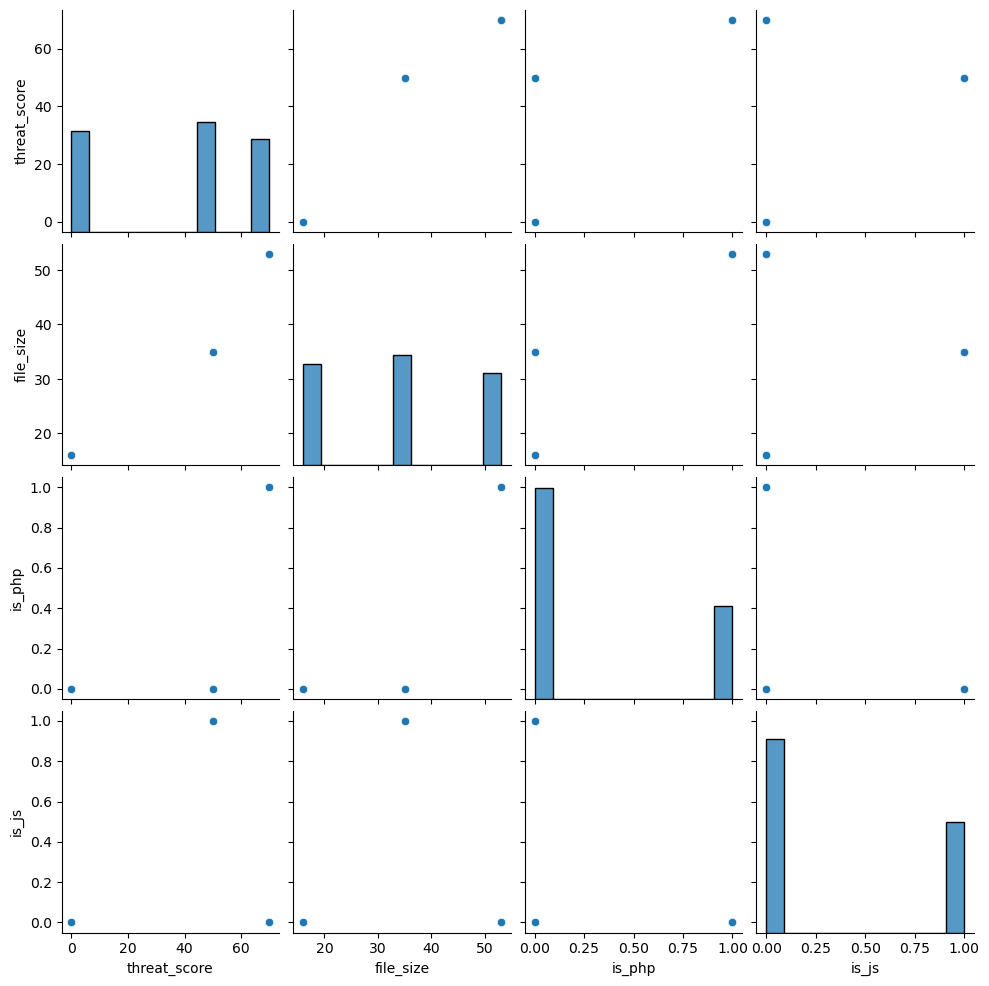

In [5]:
# Verifica se há valores nulos
print(df.isnull().sum())

# Mostra estatísticas básicas
print(df.describe())

# Converte colunas booleanas se necessário
if df['is_php'].dtype != 'int64':
    df['is_php'] = df['is_php'].astype(int)
if df['is_js'].dtype != 'int64':
    df['is_js'] = df['is_js'].astype(int)

# Visualização opcional
sns.pairplot(df[['threat_score', 'file_size', 'is_php', 'is_js']])
plt.show()


## 3. Treinamento com Isolation Forest

In [6]:
features = ['threat_score', 'file_size', 'is_php', 'is_js']
X = df[features]

# IsolationForest: -1 é anomalia, 1 é normal
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model.fit(X)

# Predição (rótulos -1 e 1)
predictions = model.predict(X)
df['predicted'] = predictions


## 4. Avaliação (Simples)

In [7]:
# Supondo que você tenha rótulo real, chamado 'label'
# 1 = normal, -1 = anomalia
if 'label' in df.columns:
    print(confusion_matrix(df['label'], df['predicted']))
    print(classification_report(df['label'], df['predicted']))
else:
    print("Aviso: Coluna 'label' não encontrada. Apenas mostrando a distribuição de predições.")
    print(df['predicted'].value_counts())


Aviso: Coluna 'label' não encontrada. Apenas mostrando a distribuição de predições.
predicted
1    775
Name: count, dtype: int64


## 5. Salvamento do Modelo

In [8]:
joblib.dump(model, "imunno_model.joblib")
print("Modelo salvo como 'imunno_model.joblib'")


Modelo salvo como 'imunno_model.joblib'
